# single zone with uncertainty example

"""
Example of creating a CDCM system of a YABML
single zone with uncertainty building.

Author(s):
    Sreehari Manikkan

Date:
    05/23/2022
"""

We start with importing the required standard libraries, packages,
modules and functions. We import h5py which enables us to use hdf5 format
data storing while using python. We import YABML which is the in house building
description and modeling python package. We then import CDCM which is
the in house python package for modeling general dynamical systems.
From *building_system* module, we import *make_building_cdcm_system* function
which essentially outputs the CDCM system corresponding to the YABML
building object given. We import the *single_zone_building* which is a
YABML building object with uncertainty from the *single_zone_random*
module. The *single_zone_building* can be seen as a distribution of a single
zone building from which we can draw samples of random building.

In [1]:
import h5py
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from yabml import *
from cdcm import *

from building_system import make_building_cdcm_system
from single_zone_random import single_zone_building

Next we create a panda dataframe -- df from the weather_data_2017_pandas.csv file. This csv file contains weather data
of 2017. Using the dataframe, a CDCM data system called *weather_sys* is created by calling the *make_data_system* function available in CDCM.

In [2]:
df = pd.read_csv("./rc_system_data/weather_data_2017_pandas.csv")
def get_weather_sys(df):
    weather_sys = make_data_system(
        df[["Tout", "Qsg", "Qint"]],
        name="weather_sys",
        column_units=["degC", "Wh", "Wh"],
        column_desciptions=[
            "Outdoor air temperature",
            "Solar irradiance",
            "Internal heat gain"
        ]
    )
    return weather_sys

We create a CDCM clock system called *clock* with time step = 1800s. *test2_buildings.h5* file is created to store the simulation results. We try to simulate 9 different randomly sampled buildings. CDCM system called *building_system* corresponding to the *single_zone_building_sample* is created by passing the sampled YABML building object, weather data system and the clock system to make_building_cdcm_system() function.<br><br>
We then create a CDCM SimulationSaver object for the sampled building. This SimulationSaver object will save the simulation results at the group provided for the sampled building. All the SimulationSaver objects of sampled buildings are stored in a list called *test2_saver*.
We run the simulation by calling the forward() and tranistion() functions of the *building_system* of the sampled building inside a for loop till the maximum step given is reached.

In [3]:
clock = make_clock(1800)
file_name = "test2_buildings.h5"

if os.path.exists(file_name):
    os.remove(file_name)

file = h5py.File(file_name, "w")

sample_size = 9
building_no = 1
max_steps = 500
test2_saver = []

for single_zone_building_sample in single_zone_building.sample(sample_size):
    building_system = make_building_cdcm_system(single_zone_building_sample,
                                                get_weather_sys(df),
                                                clock)[0]
    group = f"building_{building_no}"
    file.create_group(group)
    test2_saver.append(SimulationSaver(file[group],
                                building_system,
                                max_steps=max_steps
    )
                      )

    for i in range(max_steps):
        building_system.forward()
        test2_saver[-1].save()
        building_system.transition()
    building_no += 1

['Tout' 'Qsg' 'Qint'] ['degC', 'Wh', 'Wh'] ['Outdoor air temperature', 'Solar irradiance', 'Internal heat gain'] (True, True, True)
------ R C values of the current zone -------
C_room=2716200.0, C_env=inf, C_genv=18416165.01274456,
            R_rc=inf, R_oe=0.0015115000928222074, R_er=0.15368453333333335, R_gr=0.021954933333333336,
            R_gr=0.021954933333333336
['Tout' 'Qsg' 'Qint'] ['degC', 'Wh', 'Wh'] ['Outdoor air temperature', 'Solar irradiance', 'Internal heat gain'] (True, True, True)
------ R C values of the current zone -------
C_room=2716200.0, C_env=inf, C_genv=18416165.01274456,
            R_rc=inf, R_oe=0.0015106754154705683, R_er=0.15368453333333335, R_gr=0.021954933333333336,
            R_gr=0.021954933333333336
['Tout' 'Qsg' 'Qint'] ['degC', 'Wh', 'Wh'] ['Outdoor air temperature', 'Solar irradiance', 'Internal heat gain'] (True, True, True)
------ R C values of the current zone -------
C_room=2716200.0, C_env=inf, C_genv=18416165.01274456,
            R_rc=in

We have completed the simulation and saving the results. Now let us plot the results. We fetch simulated results using the SimulationSaver objects stored in *test2_saver*. By giving the path of the variable of interest, the SimulationSaver object will give us the numpy array of the simulation results. We can plot and visualize these numpy arrays using matplotlib library. Results of 9 different randomly sampled buildings are shown.

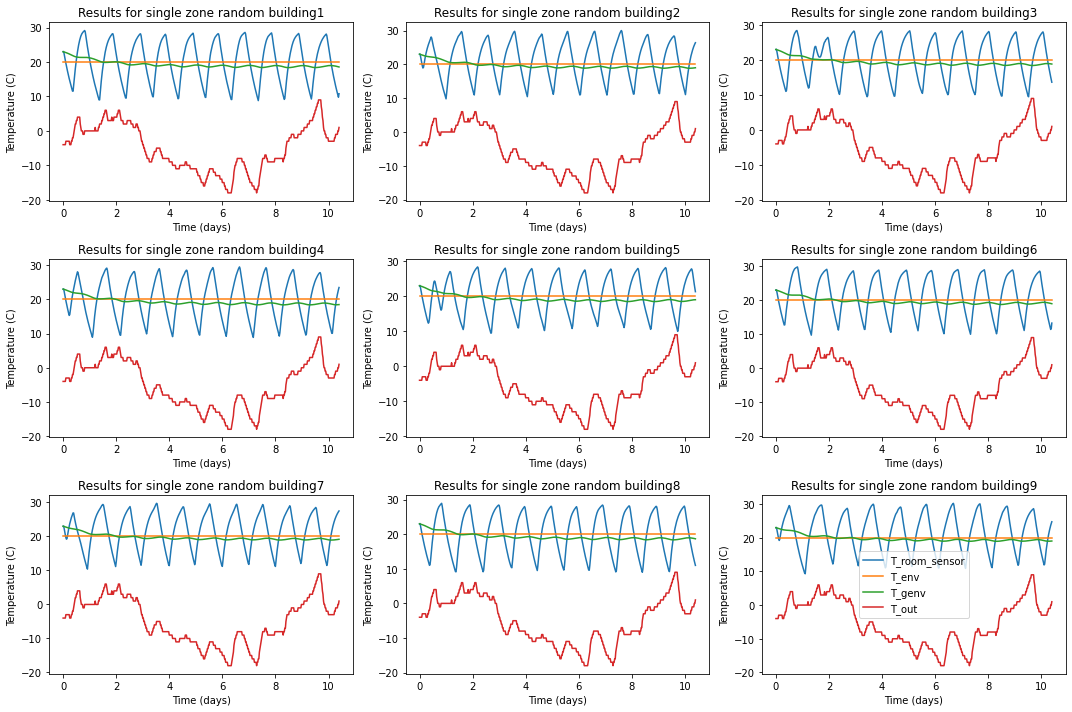

In [4]:
# Code for plotting was taken from here
# https://stackoverflow.com/questions/17210646/python-subplot-within-a-loop-first-panel-appears-in-wrong-position

fig, axs = plt.subplots(3,3, figsize=(15,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for building_no in np.arange(9):
    group = f"building_{building_no+1}"
    T_room_sensor = (
        test2_saver[building_no].group["zone_cdcm_system/zone_rc_sys/T_room_sensor"
        ][:]
    )
    T_env = (
        test2_saver[building_no].group["zone_cdcm_system/zone_rc_sys/T_env"][:]
    )
    T_genv = (
        test2_saver[building_no].group["zone_cdcm_system/zone_rc_sys/T_genv"][:]
    )
    T_out = (
        test2_saver[building_no].group["zone_cdcm_system/weather_sys/Tout"][:]
    )

    time = np.arange(max_steps) * 0.5/24
    axs[building_no].plot(time, T_room_sensor, label='T_room_sensor')
    axs[building_no].plot(time, T_env, label='T_env')
    axs[building_no].plot(time, T_genv, label='T_genv')
    axs[building_no].plot(time, T_out, label='T_out')
    axs[building_no].set_ylabel('Temperature (C)')
    axs[building_no].set_xlabel('Time (days)')
    axs[building_no].set_title(f'Results for single zone random building{building_no+1}')
fig.tight_layout()
plt.legend()
plt.show()

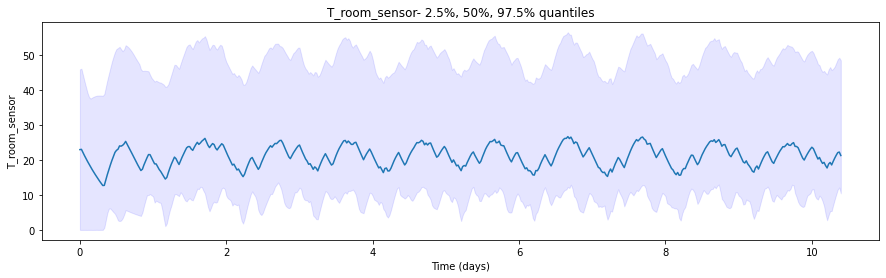

In [5]:
T_room_sensor_table =np.zeros((sample_size, max_steps))
time = np.arange(max_steps)* 0.5/24
for building_no in np.arange(sample_size):
    group = f"building_{building_no+1}"
    T_room_sensor_table[building_no] = (
        test2_saver[building_no].group["zone_cdcm_system/zone_rc_sys/T_room_sensor"
        ][:]
    )
T_room_sensor_percentiles = np.zeros((max_steps, 3))

for time_step in np.arange(0, max_steps):
    #print('2.5%, 50%, 95% quantiles of T_room_sensor at time_step =',time_step)
    T_room_sensor_percentiles[time_step] = np.percentile(T_room_sensor_table[:,time_step], [2.5, 50, 97.5])

mid = T_room_sensor_percentiles[:,1]
low = T_room_sensor_percentiles[:,0]
high = T_room_sensor_percentiles[:,2]
plt.figure(figsize=(15,4))
plt.plot(time, mid)
# Plot the confidence interval
plt.fill_between(time, (mid-low), (mid+high), color='blue', alpha=0.1)
plt.xlabel('Time (days)')
plt.ylabel('T_room_sensor')
plt.title('T_room_sensor- 2.5%, 50%, 97.5% quantiles')
plt.show()